Note: This notebook is based on the JuliaCon 2017 workshop notebook by David P. Sanders, available here:
https://github.com/dpsanders/julia_towards_1.0

# Non-standard string literals

Example: Write rationals using standard syntax (1/3)

In [1]:
macro rat_str(s)
    @show s
    return nothing
end

@rat_str (macro with 1 method)

In [2]:
rat"1/3"

s = "1/3"


In [3]:
macro rat_str(s)
    # @show s
    
    !contains(s, "/") && throw(ArgumentError("Must contain /"))
    
    num, den = split(s, "/")
    
    # @show num, den
    
    n, d = parse.((num, den))
    
    return Rational(n, d)
    
end

@rat_str (macro with 1 method)

In [6]:
rat"1 / 3"

1//3

- Metaprogramming: Access to structure of code expressions
- Macros
- MacroTools.jl

# Expressions and syntax trees

A Julia expression is an unevaluated tree of symbols. We can create an expression object using `:(...)` or `quote`:

In [29]:
ex = :(x^2 + y^2)

:(x ^ 2 + y ^ 2)

In [30]:
ex = quote
        x^2 + y^2
end

quote  # In[30], line 2:
    x ^ 2 + y ^ 2
end

We can see the internal structure with `dump` or `Meta.show_sexpr`:

In [27]:
dump(ex)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol ^
        2: Symbol x
        3: Int64 2
      typ: Any
    3: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol ^
        2: Symbol y
        3: Int64 2
      typ: Any
  typ: Any


In [28]:
Meta.show_sexpr(ex)

(:call, :+, (:call, :^, :x, 2), (:call, :^, :y, 2))

We can also see it visually with the `TreeView` package I wrote:

In [3]:
Pkg.add("TreeView")  # needs LaTeX installed on your system

INFO: Package TreeView is already installed
INFO: METADATA is out-of-date — you may not have the latest version of TreeView
INFO: Use `Pkg.update()` to get the latest versions of your packages


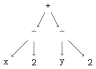

In [6]:
using TreeView

@tree x^2 + y^2

## Walking a tree

We can walk through a tree recursively:

In [17]:
function traverse(ex)
    println("Found $ex")
end
        

function traverse(ex::Expr)
    println("Processing expression with head $(ex.head)")
    
    for arg in ex.args
        println("Processing argument $arg")
        
        traverse(arg)  # recursive
    end
end
   

traverse (generic function with 2 methods)

In [18]:
traverse(:(x^2 + y^2))

Processing expression with head call
Processing argument +
Found +
Processing argument x ^ 2
Processing expression with head call
Processing argument ^
Found ^
Processing argument x
Found x
Processing argument 2
Found 2
Processing argument y ^ 2
Processing expression with head call
Processing argument ^
Found ^
Processing argument y
Found y
Processing argument 2
Found 2


## Exercise

Return a list of all the (non-numeric) symbols in the expression. Hint: you will need to keep track of all the symbols seen so far. 

## Solution to the exercise 

In [7]:
function traverse!(ex, symbols)
    # nothing here!
end

function traverse!(ex::Symbol, symbols)
    push!(symbols, ex)
end
        

function traverse!(ex::Expr, symbols)
    
    if ex.head == :call  # function call
        
        for arg in ex.args[2:end]
            traverse!(arg, symbols)  # recursive
        end
        
    else
    
        for arg in ex.args
            traverse!(arg, symbols)  # recursive
        end
    end
end

function traverse(ex::Expr) 
    symbols = Symbol[]
    traverse!(ex, symbols)
    
    return symbols
end
    

traverse (generic function with 1 method)

In [8]:
Meta.show_sexpr(:(3 + 4))

(:call, :+, 3, 4)

In [9]:
traverse(:(x^2 + y^2))

2-element Array{Symbol,1}:
 :x
 :y

In [10]:
traverse(:(x^2 + y^2 + x))

3-element Array{Symbol,1}:
 :x
 :y
 :x

## Exercise

Remove the duplication in the list.

## Building a function

Now let's build a function using the list of symbols:

In [11]:
function build_function(ex::Expr)
    symbols = unique(traverse(ex))
    
    symbol_tuple = Expr(:tuple, symbols...)
end

build_function (generic function with 1 method)

In [12]:
build_function(:(x^2 + y^2))

:((x, y))

In [13]:
function build_function(ex::Expr)
    symbols = unique(traverse(ex))
    
    symbol_tuple = Expr(:tuple, symbols...)
    
    :($symbol_tuple -> $ex)
end

build_function (generic function with 1 method)

In [14]:
build_function(:(x^2 + y^2 + x))

:((x, y)->begin  # In[13], line 6:
            x ^ 2 + y ^ 2 + x
        end)

# Macros

To make this user-friendly, we need to write a **macro**. 
This is a kind of "super-function": it takes as argument an expression, from which it calculates a new expression.
When the macro returns, the new expression is **automatically evaluated**.    

Furthermore, the argument of the macro is **automatically converted** into an `Expr` object:

In [19]:
macro make_function(ex)
    return build_function(ex)
end

@make_function (macro with 1 method)

In [21]:
f = @make_function x^2 + y^2 + x

(::#3) (generic function with 1 method)

In [22]:
f(3, 4)

28

We can use `@macroexpand` to see what effect a macro has:

The macro **replaces** the original piece of code before the new piece, before any evaluation takes place.

## Exercise
Make a macro that turns + into -, e.g.:
`1+2` becomes `1-2`.

### Hint 1
Check the structure of some possibilities:

In [11]:
dump(:(1+2))

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Int64 1
    3: Int64 2
  typ: Any


In [12]:
dump(:(1+2+3))

Expr
  head: Symbol call
  args: Array{Any}((4,))
    1: Symbol +
    2: Int64 1
    3: Int64 2
    4: Int64 3
  typ: Any


In [16]:
dump(:((1-2)*(3-2)))

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol *
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol -
        2: Int64 1
        3: Int64 2
      typ: Any
    3: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol -
        2: Int64 3
        3: Int64 2
      typ: Any
  typ: Any


### Hint 2
Use a recursive function to traverse the expression tree:

In [5]:
function replace_symbol!(ex, s::Symbol, replacement::Symbol)
    # return the replacement when ex matches s
end

function replace_symbol!(ex::Expr, s::Symbol, replacement::Symbol)
    # loop over ex.args, replacing each using replace_symbol!
end

macro plustominus(ex)
    # use the function here to return the transformed expression
end

@plustominus (macro with 1 method)

In [8]:
@macroexpand @plustominus (1+2)*(3+2)

:((1 - 2) * (3 - 2))

In [9]:
@macroexpand @plustominus 1+2+3-4

:(-(1, 2, 3) - 4)

In [10]:
@plustominus 1+2+3-4

LoadError: [91mMethodError: no method matching -(::Int64, ::Int64, ::Int64)[0m
Closest candidates are:
  -(::T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}, ::T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} at int.jl:31
  -(::T<:Number, ::T<:Number) where T<:Number at promotion.jl:337
  -(::Number, ::Number) at promotion.jl:251
  ...[39m

Note that the recursion behavior for macros is different:

In [1]:
macro testrecurse(x)
    if x == 1
        return x
    end
    println("decrementing $x")
    @testrecurse x-1
end

LoadError: [91mUndefVarError: @testrecurse not defined[39m

In [2]:
function testrecursef(x)
    if x == 1
        return x
    end
    println("decrementing $x")
    testrecursef(x-1)
end

testrecursef (generic function with 1 method)

In [3]:
testrecursef(3)

decrementing 3
decrementing 2


1

## Dict example
A Dict is an associative container:

In [8]:
mydict = Dict("a"=>1, "b"=>5, "c"=>7)

Dict{String,Int64} with 3 entries:
  "c" => 7
  "b" => 5
  "a" => 1

In [9]:
mydict["a"]

1

In [10]:
mydict["c"]

7

In [11]:
mydict["d"]

LoadError: [91mKeyError: key "d" not found[39m

In [12]:
mydict["d"] = 13

13

In [13]:
mydict["d"]

13

Can you write a macro that makes it possible to access Dict elements using ".", e.g.
```
@dictdot mydict.d
=> 13
```

In [14]:
dump(:(mydict.d))

Expr
  head: Symbol .
  args: Array{Any}((2,))
    1: Symbol mydict
    2: QuoteNode
      value: Symbol d
  typ: Any


In [27]:
macro dictdot(ex)
    if isa(ex, Expr) && ex.head == :(.)
        return :($(ex.args[1])[$(string(ex.args[2].args[1]))])
    end
end

@dictdot (macro with 1 method)

In [30]:
@dictdot mydict.d

13

Note that hygiene will ruin it in a module:

In [31]:
@macroexpand @dictdot mydict.d

:((Main.mydict)["d"])

In [32]:
module MyDictMod
    macro dictdot(ex)
        if isa(ex, Expr) && ex.head == :(.)
            return :($(ex.args[1])[$(string(ex.args[2].args[1]))])
        end
    end
end

MyDictMod

In [33]:
using MyDictMod

In [34]:
MyDictMod.@dictdot mydict.d

LoadError: [91mUndefVarError: mydict not defined[39m

In [35]:
@macroexpand MyDictMod.@dictdot mydict.d

:((MyDictMod.mydict)["d"])

Solution: escape the expression!

In [36]:
module MyDictModEscaped
    macro dictdot(ex)
        if isa(ex, Expr) && ex.head == :(.)
            return :($(esc(ex.args[1]))[$(string(ex.args[2].args[1]))])
        end
    end
end

MyDictModEscaped

In [37]:
MyDictModEscaped.@dictdot mydict.d

13

In [38]:
@macroexpand MyDictModEscaped.@dictdot mydict.d

:(mydict["d"])

# Generated functions
The following shows how to create an efficient fixed-size matrix product

In [3]:
"""
Statically sized matrix with number type T
"""
struct FixedMat{T, Rows, Cols}
    """
    The Matrix coefficients are stored as a tuple of rows, with each row itself a tuple
    """
    coefs::NTuple{Rows,NTuple{Cols,T}}
end

FixedMat

In [5]:
# Construction
FixedMat(((1.0,2.0),(3.0,4.0)))

FixedMat{Float64,2,2}(((1.0, 2.0), (3.0, 4.0)))

In [6]:
# Basic multiplication overload throws an error
import Base.*
*(A::FixedMat, B::FixedMat) = error("Invalid matrix multiplication: $(typeof(A)) ⋅ $(typeof(B))")

* (generic function with 182 methods)

In [7]:
#test
FixedMat(((1.0,2.0),(3.0,4.0))) * FixedMat(((1.0,2.0),(3.0,4.0)))

LoadError: [91mInvalid matrix multiplication: FixedMat{Float64,2,2} ⋅ FixedMat{Float64,2,2}[39m

Let's see the difference between a macro, a function and a generated function

In [15]:
function normalfoo(x)
    println("x: $x")
    return 1
end

normalfoo (generic function with 1 method)

In [16]:
macro macrofoo(x)
    println("x: $x")
    return :(1)
end

@macrofoo (macro with 1 method)

In [17]:
@generated function generatedfoo(x) # x is actually the type of the argument!
    # Called only at compile-time, normal println not allowed!
    ccall(:jl_,Void,(Any,), "x: $x")
    return :(1) # Like macros, generated functions return an expression, which is the body of the function here
end

generatedfoo (generic function with 1 method)

In [18]:
arg = 2.0

2.0

In [19]:
normalfoo(arg)

x: 2.0


1

In [20]:
@macrofoo arg

x: arg


1

In [21]:
generatedfoo(arg)

"x: Float64"


1

In [22]:
# Was already compiled for FLoat64:
generatedfoo(3.0)

1

In [23]:
# Not for Int:
generatedfoo(1)

"x: Int64"


1

Now we know what a generated function is, let's implement the matrix multiplication:

In [72]:
@generated function *(A::FixedMat{T,Rows,N}, B::FixedMat{T,N,Cols}) where {T,Rows,Cols,N}
    rowexprs = Expr[]
    for row in 1:Rows
        rowex = :(()) # empty row tuple
        for col in 1:Cols
            elex = :(+()) # Each element is a sum
            for i in 1:N
                push!(elex.args, :(A.coefs[$row][$i]*B.coefs[$i][$col]))
            end
            push!(rowex.args, elex)
        end
        push!(rowexprs, rowex)
    end
    return quote # quote is a multi-line version of :() for expressions
        return FixedMat{T,Rows,Cols}(tuple($(rowexprs...)))
    end
end

* (generic function with 183 methods)

In [25]:
FixedMat(((1.0,2.0),(3.0,4.0))).coefs[1][1]

1.0

In [28]:
dump(:((3*4,5*6)))

Expr
  head: Symbol tuple
  args: Array{Any}((2,))
    1: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol *
        2: Int64 3
        3: Int64 4
      typ: Any
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol *
        2: Int64 5
        3: Int64 6
      typ: Any
  typ: Any


In [29]:
dump(:(+()))

Expr
  head: Symbol call
  args: Array{Any}((1,))
    1: Symbol +
  typ: Any


In [40]:
A = FixedMat(((2,0,0),(0,2,0),(0,0,2)))

FixedMat{Int64,3,3}(((2, 0, 0), (0, 2, 0), (0, 0, 2)))

In [41]:
b = FixedMat(((1,),(2,),(3,)))

FixedMat{Int64,3,1}(((1,), (2,), (3,)))

In [42]:
A*b

FixedMat{Int64,3,1}(((2,), (4,), (6,)))

In [43]:
using BenchmarkTools

In [73]:
@btime $A*$b

  6.295 ns (0 allocations: 0 bytes)


FixedMat{Int64,3,1}(((2,), (4,), (6,)))

In [74]:
@code_native A*b

	.section	__TEXT,__text,regular,pure_instructions
Filename: In[72]
	pushq	%rbp
	movq	%rsp, %rbp
Source line: 15
	movq	(%rdx), %r8
	movq	8(%rdx), %r11
	movq	(%rsi), %r9
	imulq	%r8, %r9
	movq	8(%rsi), %rcx
	imulq	%r11, %rcx
	addq	%r9, %rcx
	movq	16(%rdx), %rdx
	movq	16(%rsi), %r9
	imulq	%rdx, %r9
	addq	%rcx, %r9
	movq	24(%rsi), %r10
	imulq	%r8, %r10
	movq	32(%rsi), %rcx
	imulq	%r11, %rcx
	addq	%r10, %rcx
	movq	40(%rsi), %rax
	imulq	%rdx, %rax
	addq	%rcx, %rax
	imulq	48(%rsi), %r8
	imulq	56(%rsi), %r11
	addq	%r8, %r11
	imulq	64(%rsi), %rdx
	addq	%r11, %rdx
Source line: 2
	movq	%r9, (%rdi)
	movq	%rax, 8(%rdi)
	movq	%rdx, 16(%rdi)
	movq	%rdi, %rax
	popq	%rbp
	retq
	nop


In [56]:
b*b

LoadError: [91mInvalid matrix multiplication: FixedMat{Int64,3,1} ⋅ FixedMat{Int64,3,1}[39m

In [57]:
A*A

FixedMat{Int64,3,3}(((4, 0, 0), (0, 4, 0), (0, 0, 4)))

Test with floating point values

In [65]:
Af = FixedMat(((2.0,0.0,0.0),(0.0,2.0,0.0),(0.0,0.0,2.0)))
bf = FixedMat(((1.0,),(2.0,),(3.0,)))

FixedMat{Float64,3,1}(((1.0,), (2.0,), (3.0,)))

In [61]:
_0 = Float32(0.0)
_1 = Float32(1.0)
_2 = Float32(2.0)
_3 = Float32(3.0)
Af = FixedMat(((_2,_0,_0),(_0,_2,_0),(_0,_0,_2)))
bf = FixedMat(((_1,),(_2,),(_3,)))

FixedMat{Float32,3,1}(((1.0f0,), (2.0f0,), (3.0f0,)))

In [63]:
@btime $Af * $bf

  10.776 ns (0 allocations: 0 bytes)


FixedMat{Float32,3,1}(((2.0f0,), (4.0f0,), (6.0f0,)))

In [75]:
@code_native Af * bf

	.section	__TEXT,__text,regular,pure_instructions
Filename: In[72]
	pushq	%rbp
	movq	%rsp, %rbp
Source line: 15
	movsd	(%rdx), %xmm1           ## xmm1 = mem[0],zero
	movsd	8(%rdx), %xmm0          ## xmm0 = mem[0],zero
	movsd	(%rsi), %xmm2           ## xmm2 = mem[0],zero
	mulsd	%xmm1, %xmm2
	movsd	8(%rsi), %xmm3          ## xmm3 = mem[0],zero
	mulsd	%xmm0, %xmm3
	addsd	%xmm2, %xmm3
	movsd	16(%rdx), %xmm2         ## xmm2 = mem[0],zero
	movsd	16(%rsi), %xmm4         ## xmm4 = mem[0],zero
	mulsd	%xmm2, %xmm4
	addsd	%xmm3, %xmm4
	movsd	24(%rsi), %xmm3         ## xmm3 = mem[0],zero
	mulsd	%xmm1, %xmm3
	movsd	32(%rsi), %xmm5         ## xmm5 = mem[0],zero
	mulsd	%xmm0, %xmm5
	addsd	%xmm3, %xmm5
	movsd	40(%rsi), %xmm3         ## xmm3 = mem[0],zero
	mulsd	%xmm2, %xmm3
	addsd	%xmm5, %xmm3
	mulsd	48(%rsi), %xmm1
	mulsd	56(%rsi), %xmm0
	addsd	%xmm1, %xmm0
	mulsd	64(%rsi), %xmm2
	addsd	%xmm0, %xmm2
Source line: 2
	movsd	%xmm4, (%rdi)
	movsd	%xmm3, 8(%rdi)
	movsd	%xmm2, 16(%rdi)
	movq	%rdi, %rax
	pop

Compare with arrays:

In [48]:
Aarr = [2 0 0; 0 2 0; 0 0 2]

3×3 Array{Int64,2}:
 2  0  0
 0  2  0
 0  0  2

In [49]:
barr = [1,2,3]

3-element Array{Int64,1}:
 1
 2
 3

In [51]:
@btime $Aarr * $barr

  67.268 ns (1 allocation: 112 bytes)


3-element Array{Int64,1}:
 2
 4
 6

In [55]:
@which Aarr*barr

*(A::AbstractArray{T,2}, x::AbstractArray{S,1}) where {T, S} in Base.LinAlg at linalg/matmul.jl:78

In [76]:
# Print out the code:
function mulexpr(A::Type{FixedMat{T,Rows,N}}, B::Type{FixedMat{T,N,Cols}}) where {T,Rows,Cols,N}
    rowexprs = Expr[]
    for row in 1:Rows
        rowex = :(()) # empty row tuple
        for col in 1:Cols
            elex = :(+()) # Each element is a sum
            for i in 1:N
                push!(elex.args, :(A.coefs[$row][$i]*B.coefs[$i][$col]))
            end
            push!(rowex.args, elex)
        end
        push!(rowexprs, rowex)
    end
    return quote # quote is a multi-line version of :() for expressions
        return FixedMat{T,Rows,Cols}(tuple($(rowexprs...)))
    end
end

mulexpr (generic function with 1 method)

In [78]:
mulexpr(typeof(A), typeof(b))

quote  # In[76], line 16:
    return FixedMat{T, Rows, Cols}(tuple(((A.coefs[1])[1] * (B.coefs[1])[1] + (A.coefs[1])[2] * (B.coefs[2])[1] + (A.coefs[1])[3] * (B.coefs[3])[1],), ((A.coefs[2])[1] * (B.coefs[1])[1] + (A.coefs[2])[2] * (B.coefs[2])[1] + (A.coefs[2])[3] * (B.coefs[3])[1],), ((A.coefs[3])[1] * (B.coefs[1])[1] + (A.coefs[3])[2] * (B.coefs[2])[1] + (A.coefs[3])[3] * (B.coefs[3])[1],)))
end